In [1]:
import os
import numpy as np
from PIL import Image
import torch
from torchvision import models, transforms
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import matplotlib.pyplot as plt
import joblib as jb
import cv2
from skimage.morphology import skeletonize

In [20]:
image = os.listdir(os.path.join('static', 'test'))
image

['0',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

In [21]:
all_img = []
for i in image:
    for j in os.listdir(os.path.join('static', 'test', i)):
        all_img.append(os.path.join('static', 'test', i, j))

In [22]:
jb.dump(all_img,open('all_imag.jbl','wb'))

In [23]:
leaf_model=jb.load('all_imag.jbl','rb')

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Bỏ layer phân loại
model = model.to(device)
model.eval()


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [29]:
def extract_hu_moments(img):
    """
    Trích xuất Hu Moments từ ảnh xám.
    Áp dụng log-scale để ổn định giá trị.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    moments = cv2.moments(gray)
    hu = cv2.HuMoments(moments).flatten()
    # Áp dụng log-scale để ổn định giá trị
    hu_log = -np.sign(hu) * np.log10(np.abs(hu) + 1e-8)
    return hu_log

def extract_skeleton_features(img):
    """
    Trích xuất đặc trưng Skeleton từ ảnh nhị phân.
    Tính tổng số pixel skeleton.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 127, 1, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    skeleton = skeletonize(binary).astype(np.uint8)
    skeleton_sum = np.sum(skeleton)
    return np.array([skeleton_sum], dtype=np.float32)

def extract_hsv_histogram(img, bins=(8, 8, 8)):
    """
    Trích xuất HSV histogram từ ảnh.
    Chuẩn hóa histogram để giá trị nằm trong [0, 1].
    """
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist


def extract_features(img_path):
    """
    Trích xuất và chuẩn hóa các đặc trưng từ ảnh.
    Kết hợp Hu Moments, Skeleton Features, và HSV Histogram.
    """
    if not os.path.exists(img_path):
        print(f"[Error] File does not exist: {img_path}")
        return None
    try:
        # Đọc và kiểm tra ảnh
        img = cv2.imread(img_path)
        if img is None:
            print(f"[Error] Cannot read image: {img_path}")
            return None
        
        # Resize ảnh về kích thước chuẩn
        img = cv2.resize(img, (224, 224))
        
        # Trích xuất từng đặc trưng
        hu = extract_hu_moments(img)
        skeleton = extract_skeleton_features(img)
        hsv_hist = extract_hsv_histogram(img)
        
        # Chuẩn hóa từng đặc trưng
        hu = (hu - np.min(hu)) / (np.max(hu) - np.min(hu) + 1e-8)  # Chuẩn hóa Hu Moments
        skeleton = skeleton / (np.max(skeleton) + 1e-8)           # Chuẩn hóa Skeleton
        hsv_hist = hsv_hist / (np.sum(hsv_hist) + 1e-8)           # Chuẩn hóa HSV Histogram
        
        # Kết hợp các đặc trưng thành một vector duy nhất
        feature = np.concatenate([hu, skeleton, hsv_hist])
        return feature
    except Exception as e:
        print(f"[Error] Error processing {img_path}: {e}")
        return None


In [8]:
attribute = []
for file in tqdm(leaf_model):
    result = extract_features(file)
    if result is not None:
        attribute.append(result)
jb.dump(attribute, 'attribute.jbl')

  0%|          | 0/4994 [00:00<?, ?it/s]

 21%|██        | 1030/4994 [00:06<00:23, 169.07it/s]


KeyboardInterrupt: 

In [27]:
# Tách biệt các đặc trưng khi lưu vào file attribute.jbl
attribute_hu = []
attribute_sk = []
attribute_hsv = []

for file in tqdm(leaf_model):
    result = extract_features(file)
    if result is not None:
        # Tách các đặc trưng
        hu_features = result[:7]  # Hu Moments
        sk_features = result[7:8]  # Skeleton Features
        hsv_features = result[8:]  # HSV Histogram

        # Lưu từng loại vào danh sách riêng
        attribute_hu.append(hu_features)
        attribute_sk.append(sk_features)
        attribute_hsv.append(hsv_features)

# Lưu các danh sách vào các file riêng biệt
jb.dump(attribute_hu, 'attribute_hu.jbl')
jb.dump(attribute_sk, 'attribute_sk.jbl')
jb.dump(attribute_hsv, 'attribute_hsv.jbl')


100%|██████████| 4994/4994 [01:06<00:00, 75.48it/s]


['attribute_hsv.jbl']

In [6]:
# Đường dẫn tới ảnh cần kiểm tra

test_img_path = "D:\\HCSDLDPT\\static\\test\\0\\0f1197f8-a106-4ebc-ad08-42967be969a8.JPG"  # Thay bằng đường dẫn ảnh của bạn

# Trích xuất đặc trưng
feature_vector = extract_features(test_img_path)

if feature_vector is not None:
    print("✅ Đặc trưng trích xuất thành công!")
    print("Vector đặc trưng:", feature_vector)
    print("Kích thước vector:", feature_vector.shape)
else:
    print("❌ Không trích xuất được đặc trưng cho ảnh này.")

✅ Đặc trưng trích xuất thành công!
Vector đặc trưng: [6.67808956e-01 9.52600010e-01 9.99960910e-01 9.99985572e-01
 9.99999999e-01 2.09273149e-09 0.00000000e+00 6.55000000e+03
 8.76913255e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.78667086e-04 2.79017870e-04 3.98596923e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.37053580e-04 7.57334172e-04 1.19579083e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.57684926e-04 4.58386494e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.58737248e-04 1.59438772e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.99298462e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.96492308e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0

In [7]:
feature_vector = extract_features(test_img_path)

if feature_vector is not None:
    hu_vec = feature_vector[:7]
    skeleton_vec = feature_vector[7:8]
    hsv_vec = feature_vector[8:]
    print("Hu Moments vector:", hu_vec)
    print("Skeleton vector:", skeleton_vec)
    print("HSV Histogram vector:", hsv_vec)
else:
    print("❌ Không trích xuất được đặc trưng cho ảnh này.")

Hu Moments vector: [6.67808956e-01 9.52600010e-01 9.99960910e-01 9.99985572e-01
 9.99999999e-01 2.09273149e-09 0.00000000e+00]
Skeleton vector: [6550.]
HSV Histogram vector: [8.76913255e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.78667086e-04 2.79017870e-04 3.98596923e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.37053580e-04 7.57334172e-04 1.19579083e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.57684926e-04 4.58386494e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.58737248e-04 1.59438772e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.99298462e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.96492308e-05 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.

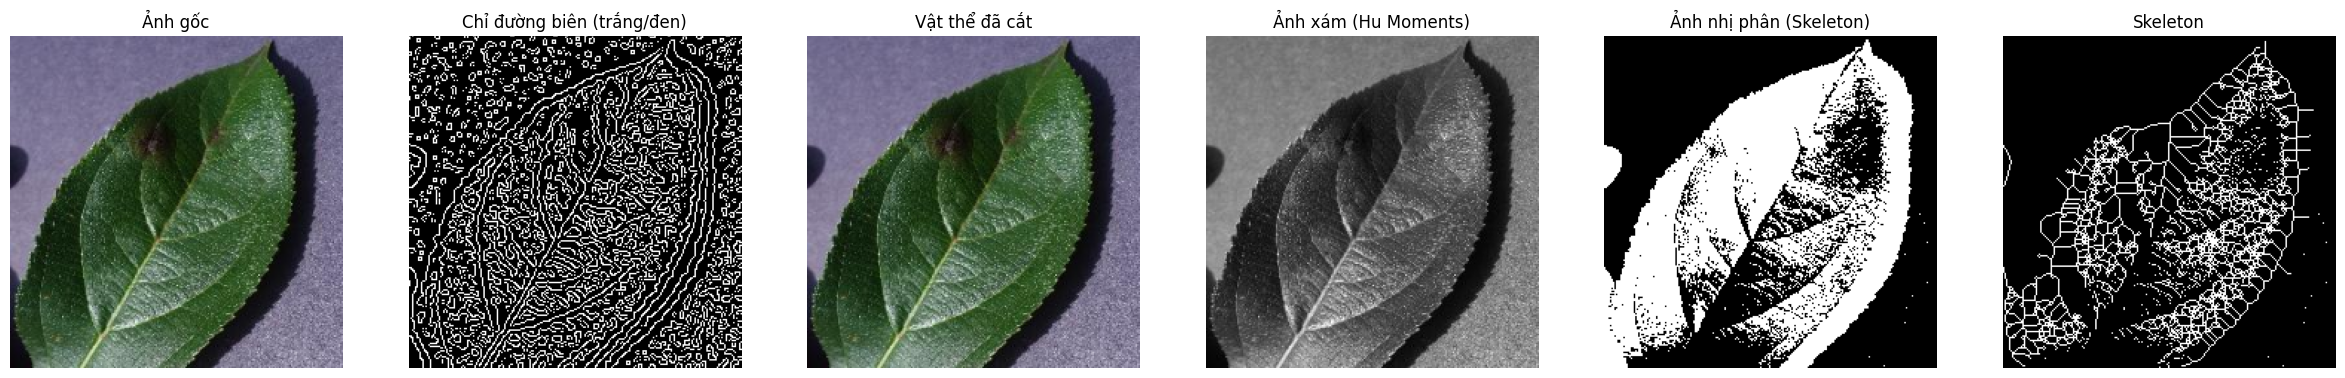

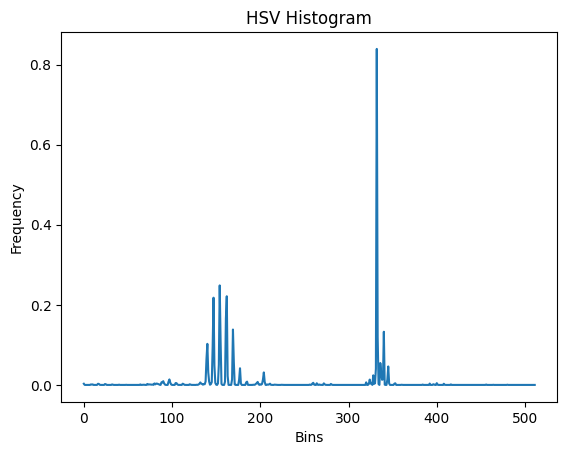

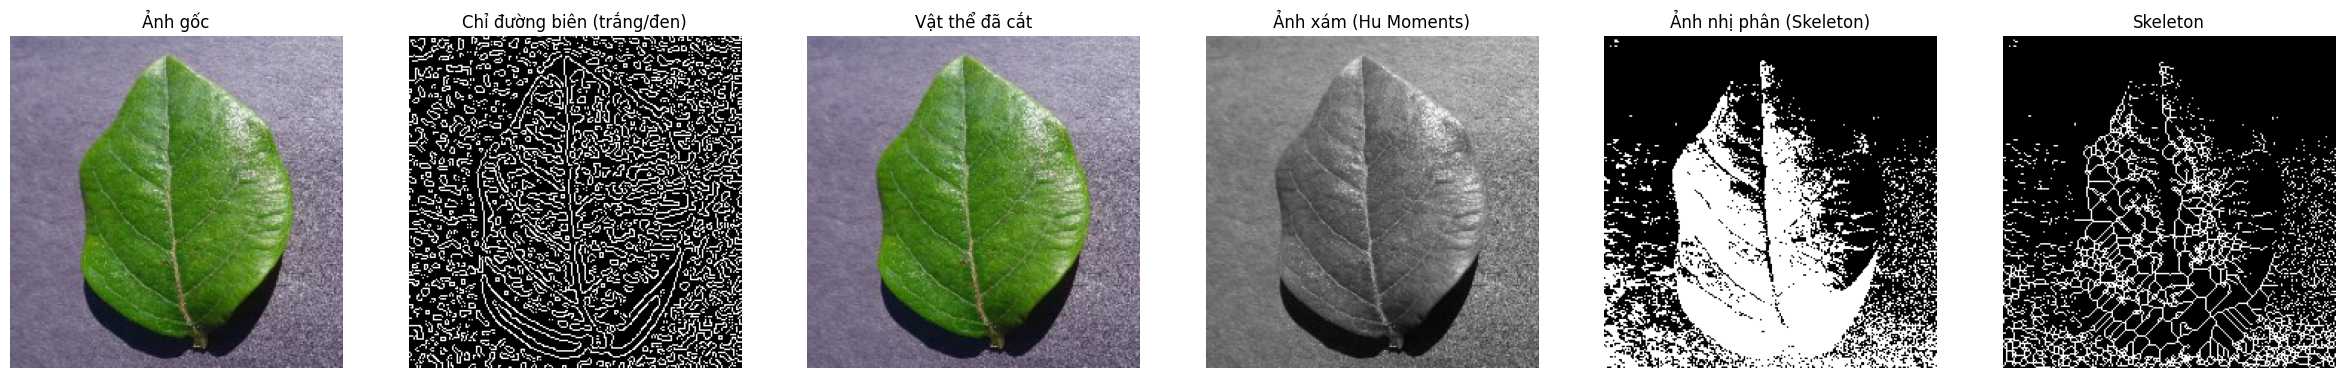

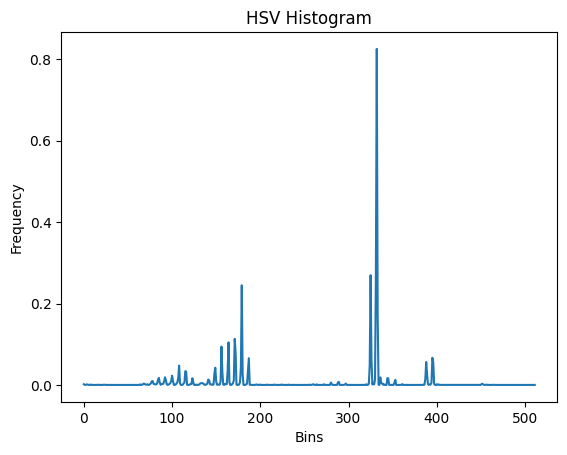

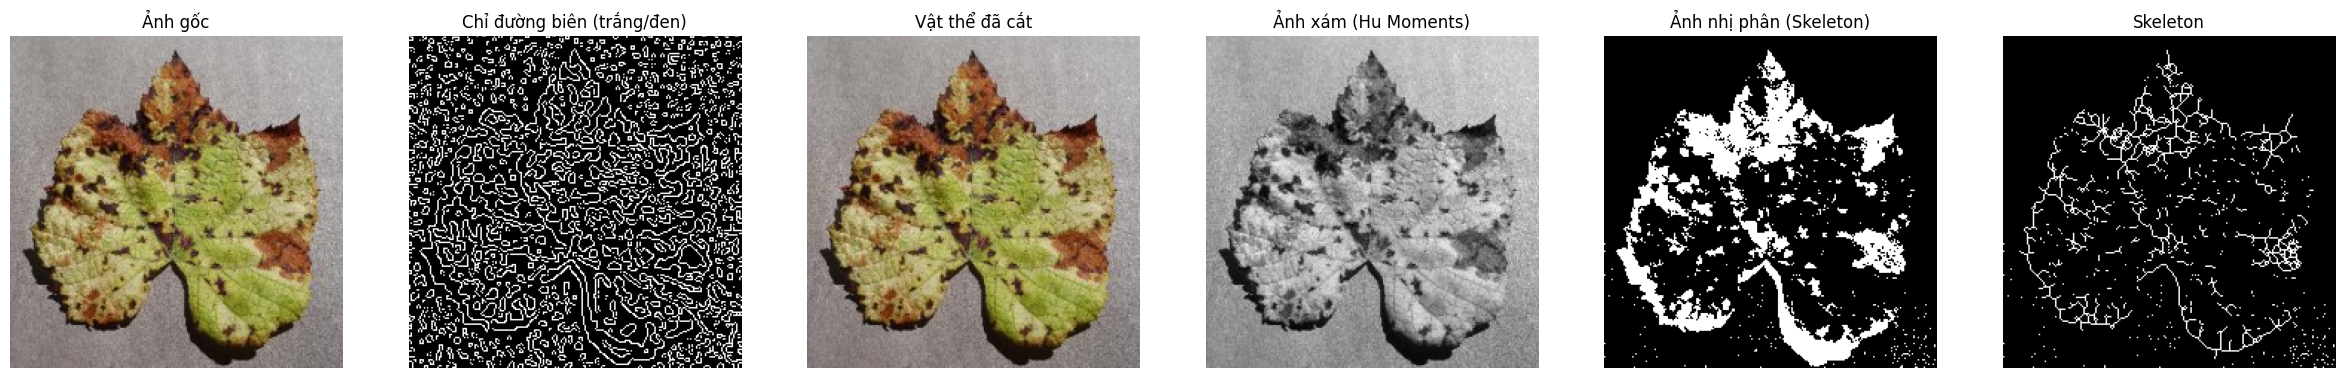

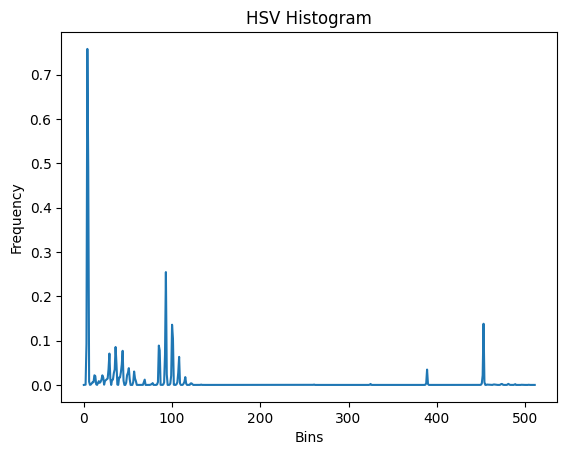

In [38]:
def visualize_feature_extraction_steps(img_path):
    img = cv2.imread(img_path)
    img_resized = cv2.resize(img, (224, 224))
    
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.adaptiveThreshold(
        blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    edges = cv2.Canny(thresh, 50, 150)
    contours, _ = cv2.findContours(
        edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    obj = img_resized

    # Vẽ contour lên ảnh để hiển thị
    contour_img = img_resized.copy()
    if contours:
        cv2.drawContours(contour_img, contours, -1, (0,255,0), 2)
        c = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(c)
        if area > 0.2 * (img_resized.shape[0] * img_resized.shape[1]):
            x, y, w, h = cv2.boundingRect(c)
            obj = img_resized[y:y+h, x:x+w]
            obj = cv2.resize(obj, (224, 224))
    
    contour_mask = np.zeros_like(gray)
    if contours:
        cv2.drawContours(contour_mask, contours, -1, (255), 1)  # Đường biên trắng, nền đen
    # 2. Hu Moments (in giá trị)
    hu = extract_hu_moments(obj)
    
    # 3. Ảnh nhị phân cho Skeleton
    gray_obj = cv2.cvtColor(obj, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray_obj, 127, 1, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # 4. Skeleton
    skeleton = skeletonize(binary).astype(np.uint8) * 255  # scale for display
    
    # 5. HSV Histogram
    hsv = cv2.cvtColor(obj, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, (8,8,8), [0,180,0,256,0,256])
    hist = cv2.normalize(hist, hist).flatten()
    
    # Hiển thị từng bước
    fig, axs = plt.subplots(1, 6, figsize=(30,5))
    axs[0].imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Ảnh gốc')
    axs[0].axis('off')

    axs[1].imshow(contour_mask, cmap='gray')
    axs[1].set_title('Chỉ đường biên (trắng/đen)')
    axs[1].axis('off')
    
    axs[2].imshow(cv2.cvtColor(obj, cv2.COLOR_BGR2RGB))
    axs[2].set_title('Vật thể đã cắt')
    axs[2].axis('off')
    
    axs[3].imshow(gray_obj, cmap='gray')
    axs[3].set_title('Ảnh xám (Hu Moments)')
    axs[3].axis('off')
    
    axs[4].imshow(binary, cmap='gray')
    axs[4].set_title('Ảnh nhị phân (Skeleton)')
    axs[4].axis('off')
    
    axs[5].imshow(skeleton, cmap='gray')
    axs[5].set_title('Skeleton')
    axs[5].axis('off')
    
    plt.figure()
    plt.plot(hist)
    plt.title('HSV Histogram')
    plt.xlabel('Bins')
    plt.ylabel('Frequency')
    plt.show()
    
    # print("Giá trị Hu Moments:", hu)
    # feature_vector = extract_features(img_path)
    # print("Vector đặc trưng kết hợp:", feature_vector)
    # print("Kích thước vector:", feature_vector.shape)

# Gọi hàm với đường dẫn ảnh của bạn
visualize_feature_extraction_steps(test_img_path)
visualize_feature_extraction_steps("D:\\HCSDLDPT\\static\\test\\4\\2b464674-d4aa-4295-81c0-c87033fab5f1.JPG")
visualize_feature_extraction_steps("D:\\HCSDLDPT\\static\\test\\13\\1afca22a-a670-41f0-9469-888cdd581c5a.JPG")

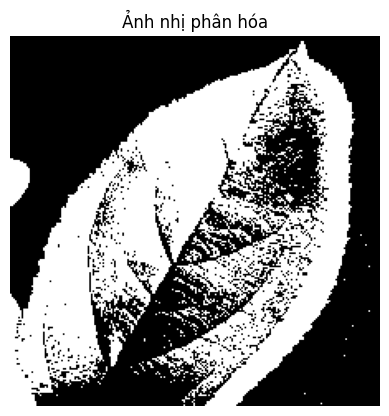

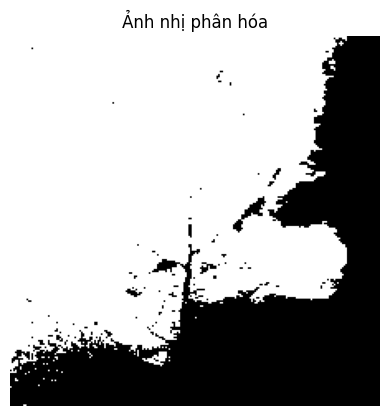

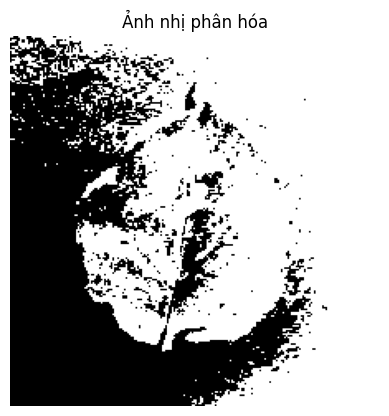

In [15]:
import cv2
import matplotlib.pyplot as plt

def show_binary_image(img_path):
    img = cv2.imread(img_path)
    img_resized = cv2.resize(img, (224, 224))
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 127, 1, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    plt.imshow(binary, cmap='gray')
    plt.title('Ảnh nhị phân hóa')
    plt.axis('off')
    plt.show()
    return binary

# Gọi hàm với đường dẫn ảnh của bạn
binary_img = show_binary_image(test_img_path)
binary_img = show_binary_image("static/test/2/1e2d9fa6-886a-4d54-8b50-6f3eb9d446d0.JPG")
binary_img = show_binary_image("D:\\HCSDLDPT\\static\\test\\2\\15ab411b-a767-4414-98db-c549427a98e3.JPG")

In [14]:
def show_images(input_path, result_paths):
    all_paths = [input_path] + result_paths
    titles = ['Input'] + [f"Similar {i+1}" for i in range(len(result_paths))]

    fig, axes = plt.subplots(1, len(all_paths), figsize=(15, 5))
    for ax, path, title in zip(axes, all_paths, titles):
        img = Image.open(path)
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    plt.show()


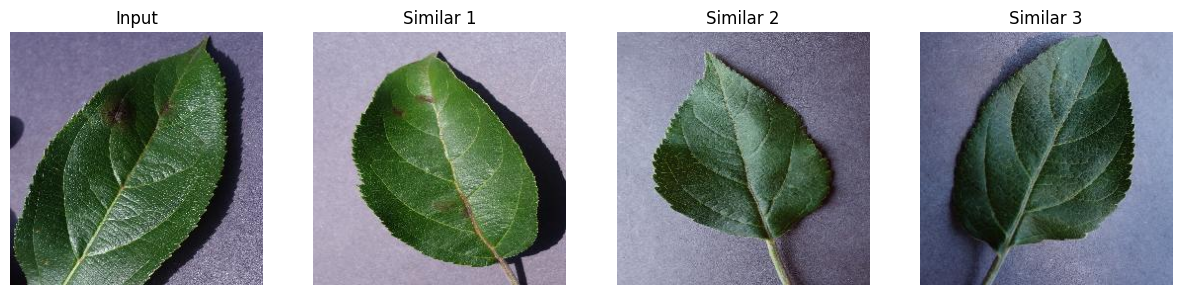

In [15]:
test_img = os.path.join(extract_path, 'test/0/0f1197f8-a106-4ebc-ad08-42967be969a8.JPG')  # <-- sửa lại đúng tên ảnh test của bạn
similar_imgs = search_similar_images(test_img)

show_images(test_img, similar_imgs)


In [16]:
correct = 0
total = 0

test_dir = os.path.join(extract_path, 'test')

for root, dirs, files in os.walk(test_dir):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            test_img_path = os.path.join(root, file)
            test_class = os.path.basename(os.path.dirname(test_img_path))
            try:
                result_paths = search_similar_images(test_img_path)
                result_classes = [os.path.basename(os.path.dirname(p)) for p in result_paths]

                if test_class in result_classes:
                    correct += 1
                total += 1
            except Exception as e:
                print(f"Lỗi với ảnh {test_img_path}: {e}")

accuracy = correct / total if total > 0 else 0
print(f"🎯 Accuracy: {accuracy * 100:.2f}% ({correct}/{total})")


🎯 Accuracy: 94.06% (9921/10547)


🖼️ Ảnh được chọn: D:\HCSDLDPT\data_distribution_for_SVM\test\35\3b08df4f-d655-4361-8152-49783f42d84a.JPG


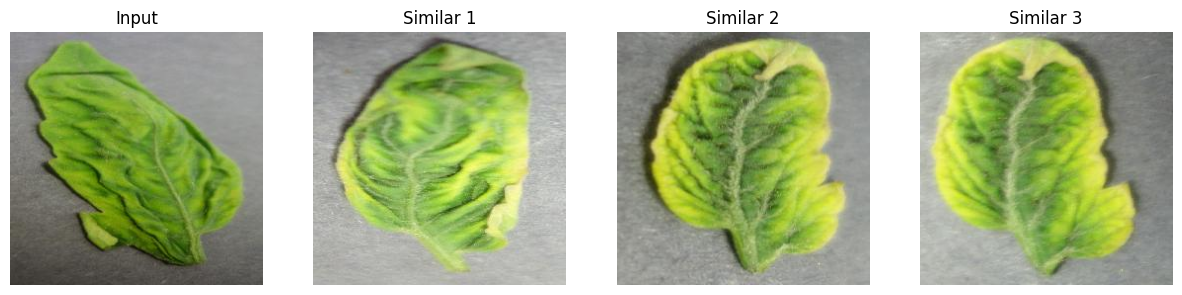

In [17]:
import random
import os

# Lấy ngẫu nhiên 1 ảnh từ test
def get_random_test_image():
    test_images = []
    for root, dirs, files in os.walk(test_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                test_images.append(os.path.join(root, file))

    # Check if test_images is empty and handle the case
    if not test_images:
        print("⚠️ Không tìm thấy ảnh nào trong thư mục test. Vui lòng kiểm tra lại đường dẫn.")
        return None  # or raise an exception, depending on your desired behavior

    return random.choice(test_images)

# Test với ảnh được chọn ngẫu nhiên
input_path = get_random_test_image()
if input_path: # Check if input_path is not None
    print(f"🖼️ Ảnh được chọn: {input_path}")
    similar_imgs = search_similar_images(input_path)
    show_images(input_path, similar_imgs)